# Numerical prediction of the phase transition curve

Similarly to https://gitlab.com/sergey.dovgal/strong-components-aux/,
we need to use FLINT which is a library written in C, but with Python interface to it.
It deals with formal power series and interval arithmetics.

If you want to reproduce this code, you need to follow these steps.

* To install the python library, follow https://fredrikj.net/python-flint/

* This requires installing FLINT http://flintlib.org/doc/building.html (integer and rational arithmetic)

* and also ARB https://arblib.org/ (interval and ball arithmetic)

Installation may take significant time, but this was the only way to deal with
numbers $n$ on the moderate scale around 1000..10000.

In [1]:
## tqdm is a progress bar, which is convenient for long computations.
from tqdm import tqdm

In [2]:
import flint

In [3]:
# Arbitrary precision real balls
from flint import arb

In [4]:
def QQ(x, y):
    """Rational numbers
    """
    return arb(x) / arb(y)

In [5]:
def arb_series_hadamard(p, q):
    """Hadamard product
    """
    return flint.arb_series([
        p_i * q_i * arb(flint.fmpz.fac_ui(n))
        for p_i, q_i, n
        in zip(p, q, range(flint.ctx.cap))
    ])

In [6]:
def proba_sat(N, _p):
    """Returns the probability that a formula with clause probability _p
    and N Boolean variables is satisfiable
    """
    flint.ctx.cap = N+1
    
    global p
    p = _p / (1 - _p)
    
    global G
    G = flint.arb_series([
        (1+p)**(n*(n-1) // 2)
        / arb(flint.fmpz.fac_ui(n))
        for n in range(flint.ctx.cap)
    ])
    
    H = flint.arb_series.sqrt(arb_series_hadamard(G, 1/G))
    
    gf_set = flint.arb_series([
        (1+p)**(-n*(n-1))
        / arb(flint.fmpz.fac_ui(n))
        for n in range(flint.ctx.cap)
    ])
    
    gf_res = arb_series_hadamard(H, gf_set) * G
    
    return (
        gf_res[N]
        * arb(2)**N
        * (1 - _p)**(N*(N-1))
        * arb(flint.fmpz.fac_ui(N))
    )

Let us compute the probability of satisfiability in the center of the
phase transition window and n = 2000.

In [7]:
%%time
n = 2000

# dps is decimal precision for floating-pt arithmetic
flint.ctx.dps = int(n*1.5)

proba_sat(n, QQ(1,2*n)).str(n=8)

CPU times: user 1.84 s, sys: 56.9 ms, total: 1.9 s
Wall time: 1.9 s


'[0.92201335 +/- 1.26e-9]'

In [8]:
def get_proba_sat(n):
    """ Get the SAT probability in the middle of the window
    """
    flint.ctx.dps = int(n*1.5)
    return float(proba_sat(n, QQ(1,2*n)).str(n=14, radius=False))

In [9]:
n_array = list(range(100, 7000, 100))
proba_array = []
for n in tqdm(n_array):
    proba_array.append(get_proba_sat(n))

100%|██████████| 69/69 [11:58<00:00, 10.41s/it]


In [10]:
import matplotlib.pyplot as plt

(0.9, 0.94)

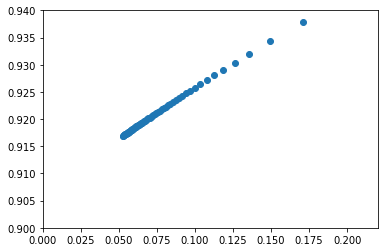

In [11]:
## Here is a plot in the scale n^{-1/3} similar
## to Deroulers and Monasson (2006)
## The points nicely fit an "almost line".

plt.scatter(
    [n**(-1/3) for n in n_array],
    proba_array
)
plt.xlim(0, 0.22)
plt.ylim(0.9, 0.94)

## Linear regression

Let us build a simple linear model predicting the probability.

In [12]:
from sklearn import linear_model
import numpy as np

In [13]:
regr_linear = linear_model.LinearRegression()
X_linear = np.array([[n**(-1/3)] for n in n_array])
Y = np.array(proba_array)
regr_linear.fit(X_linear, Y)

LinearRegression()

In [14]:
print("Prediction from linear regression:", regr_linear.predict([[0]]))

Prediction from linear regression: [0.9078674]


This number is well within the prediction from Deroulers and Monasson, but we will need to understand
better how precise it is and how to control the precision.

In [15]:
def predict(start, finish, deg):
    """Probability prediction of an arbitrary degree.
    The start and finish can be controlled in order
    to observe the stability of the prediction.
    """
    X = np.array([
        [
            n**(-k/3)
            for k in range(1, deg+1)
        ]
        for n in n_array[start:finish]
    ])
    Y = np.array(proba_array[start:finish])
    
    regr = linear_model.LinearRegression()
    
    regr.fit(X, Y)
    
    pred = regr.predict([[0 for _ in range(1, deg+1)]])[0]
    
    return pred

## The case of general mu

For plotting purposes, we do not need a high degree of regression

In [16]:
def get_proba_sat(n, p=None, prec=14):
    """ Get the SAT probability in the middle of the window
    """
    if p is None:
        p = QQ(1, 2*n)
    flint.ctx.dps = int(n*1.5)
    return float(proba_sat(n, p).str(n=prec, radius=False))

In [17]:
def limiting_p_sat(_mu):
    mu = arb(_mu)
    n_array = list(range(1000, 2100, 100))
    p_array = [
        arb(1 / (2*n) * (1 + mu * n**(-1/3)))
        for n in n_array
    ]
    sat_proba_array = []
    for n,p in zip(n_array, p_array):
        sat_proba_array.append(get_proba_sat(n, p))
    
    deg = 3
    start = None
    finish = None
    X = np.array([
        [
            n**(-k/3)
            for k in range(1, deg+1)
        ]
        for n in n_array[start:finish]
    ])
    Y = np.array(sat_proba_array[start:finish])

    regr = linear_model.LinearRegression()
    
    regr.fit(X, Y)
    
    pred = regr.predict([[0 for _ in range(1, deg+1)]])[0]
    
    return pred

In [20]:
mu_2_array = np.linspace(-4, 4, 97)
plot_2_array = []

for mu in tqdm(mu_2_array):
    plot_2_array.append(limiting_p_sat(mu))

If you don't have time to wait for the above computation to finish,
you can reuse the data from table below. The next cell contains a code to quickly
recover these values.

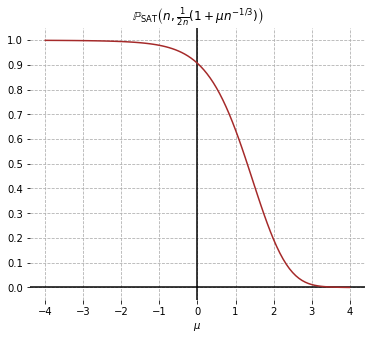

In [23]:
plt.figure(figsize=(6,5))
plt.box(on=False)
plt.axhline(y=0, color='k')
plt.axvline(x=0, color='k')
plt.grid(True, linestyle='--')
plt.yticks(np.linspace(0, 1, 11))
plt.plot(mu_2_array, plot_2_array, color='brown')
plt.xlabel(r"$\mu$")
plt.title(r"$\mathbb{P}_{\mathsf{SAT}}\left(n, \frac{1}{2n}(1 + \mu n^{-1/3})\right)$");
#plt.savefig('sat-curve-2.pdf')

Note that the negative values appear due to the fact that we do not use precise enough computations
for large values of $\mu$.
This data can be, of course, improved, but for plotting purposes we are not going to deal
with these numbers.

## The center of the scaling window

Recall that the function `predict` is designed to infer the numerical values of the satisfiability probability
based on the computed array of finite-size probabilities `proba_array` for `n_array`.
It only takes several minutes to compute an array of 69 elements, which already
allows to get some improvements over the prediction of Deroulers and Monasson.

In [24]:
n_array[:10]

[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

In [25]:
proba_array[:10]

[0.94457551215929,
 0.93778425766857,
 0.93428517412517,
 0.9320055088478,
 0.93034867302375,
 0.92906465419899,
 0.92802642122184,
 0.92716118123144,
 0.92642361112803,
 0.92578371568676]

The function `predict` has three arguments: the starting point of the array, the finishing point, and the degree of the polynomial for numerical prediction. Here is how many points we have:

In [26]:
len(n_array)

69

In [27]:
predict(None, None, 1)

0.9078673980681505

If we take the whole array and increase the degree of the polynomial, we can presumably
improve the prediction.

In [28]:
[
    predict(None, None, n)
    for n in range(1, 10)
]

[0.9078673980681505,
 0.9063150240037654,
 0.9062242404592741,
 0.9062234928844555,
 0.9062239280303666,
 0.9062239596289592,
 0.9062239607839929,
 0.9062239606884548,
 0.9062239607054431]

The sequence stabilizes itself, but it will also have less noise if we truncate the beginning of the sequence and do not consider smaller n.

In [29]:
[
    [
        predict(start, None, n)
        for start in [None, 20, 30]
    ]
    for n in range(1, 10)
]

[[0.9078673980681505, 0.9068941020843163, 0.9068184355722942],
 [0.9063150240037654, 0.9062420889174186, 0.9062388528881941],
 [0.9062242404592741, 0.9062238615636502, 0.9062238766091723],
 [0.9062234928844555, 0.9062239229778846, 0.9062239334189648],
 [0.9062239280303666, 0.9062239592306155, 0.9062239597197754],
 [0.9062239596289592, 0.9062239604375993, 0.9062239671613094],
 [0.9062239607839929, 0.9062239642293004, 0.906223935726787],
 [0.9062239606884548, 0.9062239825791572, 0.9062239364016368],
 [0.9062239607054431, 0.9062239819155126, 0.9062239364800401]]

In all the cases, the prediction of degree from 5 to 10 converges on the number
$$
    0.9062239...
$$
but the next digit is different depending on where the sequence starts.
The rest of the prediction is too noisy.

In order to better understand the behaviour of the consequent digits, we need to look into
two things.

On one hand, for polynomials of degree $10$ we expect an error
$\varepsilon \approx n^{-10/3}$, where $n = 100$, which yields $\varepsilon \approx 10^{-7}$.

On the other hand, the error depends on the magnitude of the coefficient, and we need to be
sure that by increasing the degree of the polynomial we do not create overfitting.
This can be achieved by comparing coefficient arrays for adjacent parameters.

In [30]:
100**(-10/3)

2.1544346900318822e-07

In [31]:
def show_coeff(start, finish, deg):
    """This function returns the array of coefficients of the model.
    """
    X = np.array([
        [
            n**(-k/3)
            for k in range(1, deg+1)
        ]
        for n in n_array[start:finish]
    ])
    Y = np.array(proba_array[start:finish])
    
    regr = linear_model.LinearRegression()
    
    regr.fit(X, Y)
    
    return regr.coef_

In the first dimension, we only increase the degree of the polynomial.

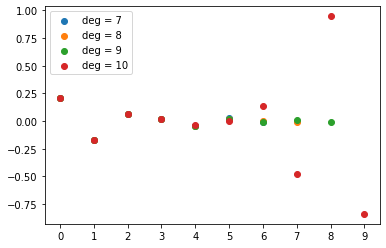

In [32]:
plt.scatter(range(7), show_coeff(None, None, 7), label="deg = 7")
plt.scatter(range(8), show_coeff(None, None, 8), label="deg = 8")
plt.scatter(range(9), show_coeff(None, None, 9), label="deg = 9")
plt.scatter(range(10), show_coeff(None, None, 10), label="deg = 10")
plt.legend()
plt.xticks(range(10));

In the second dimension, we keep polynomial degrees to 5, 6, 7 and 8, and change the truncation levels.

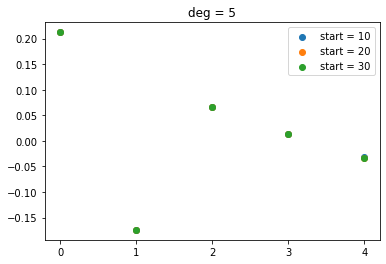

In [33]:
deg = 5

plt.scatter(range(deg), show_coeff(10, None, deg), label="start = 10")
plt.scatter(range(deg), show_coeff(20, None, deg), label="start = 20")
plt.scatter(range(deg), show_coeff(30, None, deg), label="start = 30")
plt.legend()
plt.xticks(range(deg));
plt.title("deg = "+str(deg));

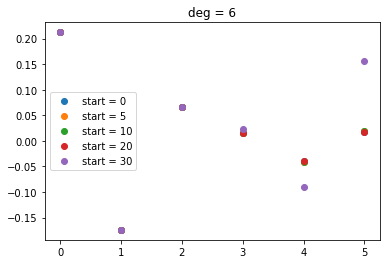

In [34]:
deg = 6

plt.scatter(range(deg),  show_coeff(0, None, deg), label="start = 0")
plt.scatter(range(deg),  show_coeff(5, None, deg), label="start = 5")
plt.scatter(range(deg), show_coeff(10, None, deg), label="start = 10")
plt.scatter(range(deg), show_coeff(20, None, deg), label="start = 20")
plt.scatter(range(deg), show_coeff(30, None, deg), label="start = 30")
plt.legend()
plt.xticks(range(deg));
plt.title("deg = "+str(deg));

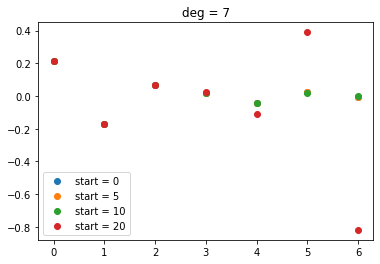

In [35]:
deg = 7

plt.scatter(range(deg),  show_coeff(0, None, deg), label="start = 0")
plt.scatter(range(deg),  show_coeff(5, None, deg), label="start = 5")
plt.scatter(range(deg), show_coeff(10, None, deg), label="start = 10")
plt.scatter(range(deg), show_coeff(20, None, deg), label="start = 20")
plt.legend()
plt.xticks(range(deg));
plt.title("deg = "+str(deg));

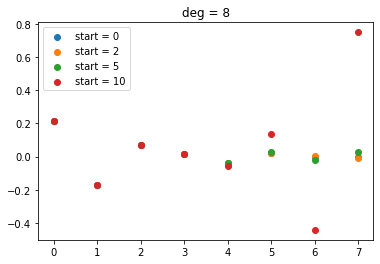

In [36]:
deg = 8

plt.scatter(range(deg),  show_coeff(0, None, deg), label="start = 0")
plt.scatter(range(deg),  show_coeff(2, None, deg), label="start = 2")
plt.scatter(range(deg),  show_coeff(5, None, deg), label="start = 5")
plt.scatter(range(deg), show_coeff(10, None, deg), label="start = 10")

plt.legend()
plt.xticks(range(deg));
plt.title("deg = "+str(deg));

With the available data, we can pick our best parameters for these four degrees.

* deg = 5, start = 30
* deg = 6, start = 20
* deg = 7, start = 7
* deg = 8, start = 1

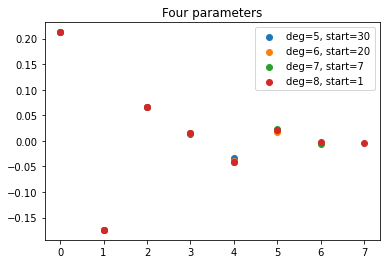

In [37]:
plt.scatter(range(5),  show_coeff(30, None, 5), label="deg=5, start=30")
plt.scatter(range(6),  show_coeff(20, None, 6), label="deg=6, start=20")
plt.scatter(range(7),  show_coeff(7, None, 7), label="deg=7, start=7")
plt.scatter(range(8), show_coeff(1, None, 8), label="deg=8, start=1")

plt.legend()
plt.xticks(range(8));
plt.title("Four parameters");

In [38]:
# And here are the numerical predictions for these four best guesses:
[
    predict(30, None, 5),
    predict(20, None, 6),
    predict(7, None, 7),
    predict(1, None, 8)
]

[0.9062239597197754,
 0.9062239604375993,
 0.9062239607079383,
 0.9062239607005699]

This yields our current best estimate
$$ p = 0.906223960 \pm 10^{-9} $$

## Hand-made linear regression in ARB, and improved precision

In order to improve precision, we need to change some parts of the code.
We are dealing with float conversion, which effectively limits our knowledge about
this constant $p$ to only 9-11 digits. Now, we need to implement our own linear
regression to not lose the precious digits. We are still using the same quantity of
points for numerical estimation, but this technique already improves the result
with the same data.

In [39]:
def get_raw_proba_sat(n, dps=None):
    """ Get the SAT probability in the middle of the window
    expressing it with ARB datatype.
    """
    if dps is None:
        flint.ctx.dps = int(n*1.5)
    else:
        flint.ctx.dps = dps
    p = QQ(1, 2*n)
    return proba_sat(n,p)

Now, the maximal $n$ is 5100, so the target precision should be around $1.5 n$.
This is expressed by using the `dps` additional argument in `get_raw_proba_sat`.
Here, we set `dps=7500`.

In [40]:
n_array = list(range(100, 5100, 50))
proba_array = []
for n in tqdm(n_array):
    proba_array.append(get_raw_proba_sat(n, dps = 7500))

100%|██████████| 100/100 [18:21<00:00, 11.01s/it]


In [45]:
## Matrices with ARB elements
from flint import arb_mat

In [41]:
def get_regression_coeffs(start, finish, deg):
    """This function returns the array of coefficients of the model.
    """
    X = arb_mat([
        [
            n**(-k/3)
            for k in range(deg+1)
        ]
        for n in n_array[start:finish]
    ])
    Y = arb_mat([[proba] for proba in proba_array[start:finish]])
    
    return ((X.transpose() * X).inv() * X.transpose() * Y).entries()

In [42]:
def to_float(array):
    return [
        float(entry.str(n=14, radius=False))
        for entry in array
    ]

In [43]:
# to float, get regression coefficients
tfgrc = lambda x,y,z: to_float(get_regression_coeffs(x, y, z))

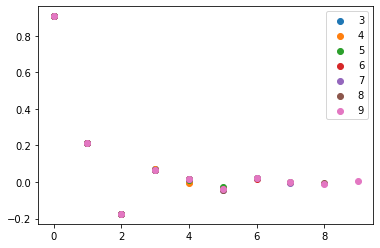

In [46]:
plt.scatter(range(4), tfgrc(None, None, 3), label="3")
plt.scatter(range(5), tfgrc(None, None, 4), label="4")
plt.scatter(range(6), tfgrc(None, None, 5), label="5")
plt.scatter(range(7), tfgrc(None, None, 6), label="6")
plt.scatter(range(8), tfgrc(None, None, 7), label="7")
plt.scatter(range(9), tfgrc(None, None, 8), label="8")
plt.scatter(range(10), tfgrc(None, None, 9), label="9")

plt.legend();

In [47]:
len(n_array)

100

In [48]:
deg = 5
tfgrc(30, None, deg)

[0.90622395805495,
 0.21231465643522,
 -0.1739727075331,
 0.066942349422913,
 0.013961609211157,
 -0.031945412168578]

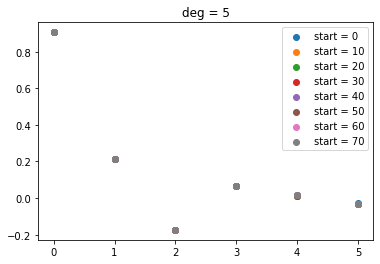

In [49]:
deg = 5

plt.scatter(range(deg + 1), tfgrc(0, None, deg), label="start = 0")
plt.scatter(range(deg + 1), tfgrc(10, None, deg), label="start = 10")
plt.scatter(range(deg + 1), tfgrc(20, None, deg), label="start = 20")
plt.scatter(range(deg + 1), tfgrc(30, None, deg), label="start = 30")
plt.scatter(range(deg + 1), tfgrc(40, None, deg), label="start = 40")
plt.scatter(range(deg + 1), tfgrc(50, None, deg), label="start = 50")
plt.scatter(range(deg + 1), tfgrc(60, None, deg), label="start = 60")
plt.scatter(range(deg + 1), tfgrc(70, None, deg), label="start = 70")

plt.legend()
plt.xticks(range(deg + 1));
plt.title("deg = "+str(deg));

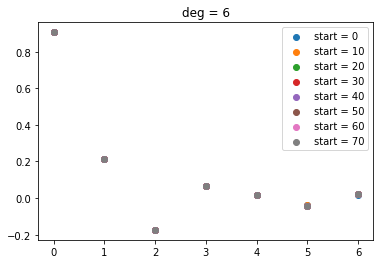

In [50]:
deg = 6

plt.scatter(range(deg + 1), tfgrc(0, None, deg), label="start = 0")
plt.scatter(range(deg + 1), tfgrc(10, None, deg), label="start = 10")
plt.scatter(range(deg + 1), tfgrc(20, None, deg), label="start = 20")
plt.scatter(range(deg + 1), tfgrc(30, None, deg), label="start = 30")
plt.scatter(range(deg + 1), tfgrc(40, None, deg), label="start = 40")
plt.scatter(range(deg + 1), tfgrc(50, None, deg), label="start = 50")
plt.scatter(range(deg + 1), tfgrc(60, None, deg), label="start = 60")
plt.scatter(range(deg + 1), tfgrc(70, None, deg), label="start = 70")

plt.legend()
plt.xticks(range(deg + 1));
plt.title("deg = "+str(deg));

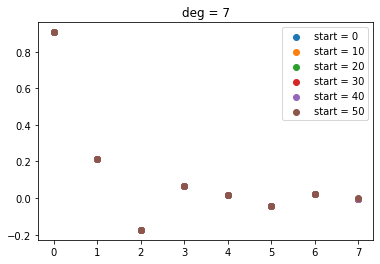

In [51]:
deg = 7

plt.scatter(range(deg + 1), tfgrc(0, None, deg), label="start = 0")
plt.scatter(range(deg + 1), tfgrc(10, None, deg), label="start = 10")
plt.scatter(range(deg + 1), tfgrc(20, None, deg), label="start = 20")
plt.scatter(range(deg + 1), tfgrc(30, None, deg), label="start = 30")
plt.scatter(range(deg + 1), tfgrc(40, None, deg), label="start = 40")
plt.scatter(range(deg + 1), tfgrc(50, None, deg), label="start = 50")

plt.legend()
plt.xticks(range(deg + 1));
plt.title("deg = "+str(deg));

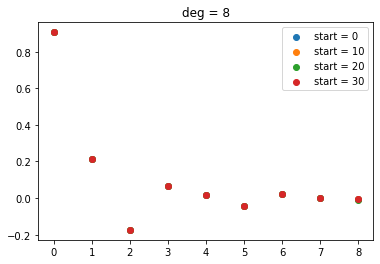

In [52]:
deg = 8

plt.scatter(range(deg + 1), tfgrc(0, None, deg), label="start = 0")
plt.scatter(range(deg + 1), tfgrc(10, None, deg), label="start = 10")
plt.scatter(range(deg + 1), tfgrc(20, None, deg), label="start = 20")
plt.scatter(range(deg + 1), tfgrc(30, None, deg), label="start = 30")

plt.legend()
plt.xticks(range(deg + 1));
plt.title("deg = "+str(deg));

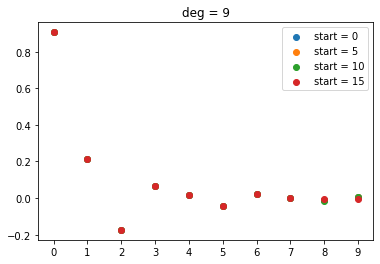

In [53]:
deg = 9

plt.scatter(range(deg + 1), tfgrc(0, None, deg), label="start = 0")
plt.scatter(range(deg + 1), tfgrc(5, None, deg), label="start = 5")
plt.scatter(range(deg + 1), tfgrc(10, None, deg), label="start = 10")
plt.scatter(range(deg + 1), tfgrc(15, None, deg), label="start = 15")

plt.legend()
plt.xticks(range(deg + 1));
plt.title("deg = "+str(deg));

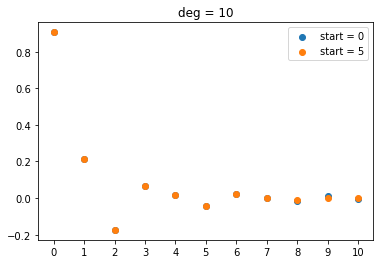

In [54]:
deg = 10

plt.scatter(range(deg + 1), tfgrc(0, None, deg), label="start = 0")
plt.scatter(range(deg + 1), tfgrc(5, None, deg), label="start = 5")


plt.legend()
plt.xticks(range(deg + 1));
plt.title("deg = "+str(deg));

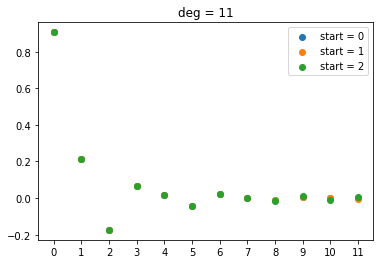

In [55]:
deg = 11

plt.scatter(range(deg + 1), tfgrc(0, None, deg), label="start = 0")
plt.scatter(range(deg + 1), tfgrc(1, None, deg), label="start = 1")
plt.scatter(range(deg + 1), tfgrc(2, None, deg), label="start = 2")


plt.legend()
plt.xticks(range(deg + 1));
plt.title("deg = "+str(deg));

In [56]:
# And here are the numerical predictions for these best guesses:
[
    get_regression_coeffs(70, None, 6)[0].str(n=25, radius=False),
    get_regression_coeffs(50, None, 7)[0].str(n=25, radius=False),
    get_regression_coeffs(30, None, 8)[0].str(n=25, radius=False),
    get_regression_coeffs(15, None, 9)[0].str(n=25, radius=False),
    get_regression_coeffs(5, None, 10)[0].str(n=25, radius=False),
    get_regression_coeffs(0, None, 11)[0].str(n=25, radius=False)
]

['0.9062239606771515290817090',
 '0.9062239606625882780547726',
 '0.9062239606751990693068827',
 '0.9062239606726282841441513',
 '0.9062239606721146157938819',
 '0.9062239606718595931672864']

This yields, by majority vote,
$$
    p = 0.90622396067 \pm 10^{-11}
$$

Here are the first several coefficients of the model:

In [58]:
[coef.str(n=11, radius=False) for coef in get_regression_coeffs(None, None, 9)]

['0.90622396067',
 '0.21231443279',
 '-0.17396477143',
 '0.066792549886',
 '0.015548697242',
 '-0.040901251457',
 '0.021015877868',
 '0.0013017069862',
 '-0.010906604132',
 '0.0044904450308']

In [59]:
[coef.str(n=11, radius=False) for coef in get_regression_coeffs(15, None, 9)]

['0.90622396067',
 '0.21231443283',
 '-0.17396477208',
 '0.066792530426',
 '0.015549691296',
 '-0.040920450295',
 '0.021223536266',
 '-2.1888170588e-5',
 '-0.0062381090263',
 '-0.0025716353858']

In [60]:
[coef.str(n=11, radius=False) for coef in get_regression_coeffs(15, None, 7)]

['0.90622396069',
 '0.21231443153',
 '-0.17396471401',
 '0.066791066848',
 '0.015572554548',
 '-0.041146710729',
 '0.022602829015',
 '-0.0046935461563']

In [61]:
[coef.str(n=11, radius=False) for coef in get_regression_coeffs(30, None, 7)]

['0.90622396068',
 '0.21231443224',
 '-0.17396474273',
 '0.066791710664',
 '0.015563928479',
 '-0.041077642182',
 '0.022296786982',
 '-0.0041145747483']

In [62]:
[coef.str(n=11, radius=False) for coef in get_regression_coeffs(30, None, 6)]

['0.90622396064',
 '0.21231443596',
 '-0.17396490106',
 '0.066795437444',
 '0.015511449727',
 '-0.040635538496',
 '0.020233607353']

In [63]:
[coef.str(n=11, radius=False) for coef in get_regression_coeffs(50, None, 6)]

['0.90622396066',
 '0.21231443435',
 '-0.17396484087',
 '0.066794241598',
 '0.015524795449',
 '-0.040714869209',
 '0.020429846411']

By comparing these different predictions we can estimate their
numerical stability and make proper truncations.
Starting from $c_7$, it is not anymore possible to obtain a prediction using our data, because the coefficients become too close to zero. Therefore, the optimal degree for numerical
prediction is $d=7$.

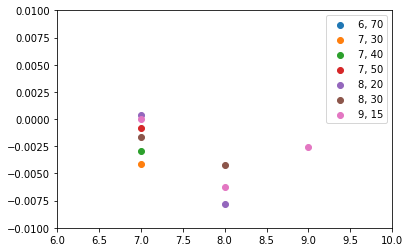

In [64]:
plt.scatter(range(7), tfgrc(70, None, 6), label="6, 70")
plt.scatter(range(8), tfgrc(30, None, 7), label="7, 30")
plt.scatter(range(8), tfgrc(40, None, 7), label="7, 40")
plt.scatter(range(8), tfgrc(50, None, 7), label="7, 50")
plt.scatter(range(9), tfgrc(20, None, 8), label="8, 20")
plt.scatter(range(9), tfgrc(30, None, 8), label="8, 30")
plt.scatter(range(10), tfgrc(15, None, 9), label="9, 15")
plt.xlim(6, 10)
plt.ylim(-0.01, 0.01)
plt.legend()

You can improve these estimates by yourself if you want!
To do this, take a larger array of n's (which results in longer computation
time for the array of probabilities),
then for several different degrees find the maximum amount at which
you can truncate, and compare the results for different degrees.
The maximal truncation gives the best "stable" guesses.

Thank you for reading! And good luck in what you are doing.

# Update: time measurements

In [1]:
import flint
from flint import arb

In [2]:
def QQ(x, y):
    """Rational numbers
    """

    return arb(x) / arb(y)

def arb_series_hadamard(p, q):
    """Hadamard product
    """

    return flint.arb_series([
        p_i * q_i * arb(flint.fmpz.fac_ui(n))
        for p_i, q_i, n
        in zip(p, q, range(flint.ctx.cap))
    ])

In [3]:
def proba_sat(N, _p):
    """Returns the probability that a formula with clause probability _p
    and N Boolean variables is satisfiable
    """
    flint.ctx.cap = N+1
    
    global p
    p = _p / (1 - _p)
    
    global G
    G = flint.arb_series([
        (1+p)**(n*(n-1) // 2)
        / arb(flint.fmpz.fac_ui(n))
        for n in range(flint.ctx.cap)
    ])
    
    H = flint.arb_series.sqrt(arb_series_hadamard(G, 1/G))
    
    gf_set = flint.arb_series([
        (1+p)**(-n*(n-1))
        / arb(flint.fmpz.fac_ui(n))
        for n in range(flint.ctx.cap)
    ])
    
    gf_res = arb_series_hadamard(H, gf_set) * G
    
    return (
        gf_res[N]
        * arb(2)**N
        * (1 - _p)**(N*(N-1))
        * arb(flint.fmpz.fac_ui(N))
    )

In [4]:
def n_sat(N):
    """Returns the number of satisfiable 2-CNF with N Boolean variables
    """    
    return proba_sat(N, QQ(1,2)) * QQ(2,1)**(2*N*(N-1))

In [5]:
proba_sat(5, QQ(1,2))

[0.0260973242320688 +/- 3.21e-17]

In [6]:
n_sat(5)

[28694311447.0000 +/- 1.99e-5]

In [7]:
%%time
n = 10
flint.ctx.dps = n*n//2
n_sat(10)

CPU times: user 274 µs, sys: 19 µs, total: 293 µs
Wall time: 299 µs


[44164928411665942510460654486808636655906527.000000 +/- 4.46e-7]

In [8]:
%%time
n = 20
flint.ctx.dps = n*(n-1)//2
n_sat(n)

CPU times: user 561 µs, sys: 10 µs, total: 571 µs
Wall time: 577 µs


[4052184006634727313218830235379382226061907031428460134916813087682168899627407190911607091759320395606062166632555323143948144723552748594703782599900071618406575770773466526513.000000000000 +/- 2.34e-13]

In [9]:
%%time
n = 40
flint.ctx.dps = n*(n-1)//2
n_sat(n)

CPU times: user 12.7 ms, sys: 1.7 ms, total: 14.4 ms
Wall time: 16.8 ms


[282741579798881911093666832356648754277797162186661255216777751310063848729368015034702720454176266579159321051555059645109096084694969081222239331609250524638913321103191417839012510922580314591625735103301289747723313469211031415749571615747854689689370343734935080209892909099384451655369155866738847568137114752063654273050353566618855543901858755370414110592435215655425526782281509876254727192549563099663763582926988065172927699983044389034170401380048079302432072237931571942391506184296952644320950026330736002000586356919715695426142685160431089130825410511089687935865772203159963986130362811457876844668439240704763367486217875231320198410518103960537005222063050897253759258002546999538434221349615344801.000000000000000000000000000000000000000000000000000000000000000 +/- 1.99e-64]

In [10]:
%%time
n = 100
flint.ctx.dps = n*(n-1)//2
n_sat(n)

CPU times: user 232 ms, sys: 12.9 ms, total: 245 ms
Wall time: 284 ms


[250285204084778957194558105317920783435011299125154138049349843172809073315386876298550212280203052357991646704412941881367389442672493894791868067101965916829412989083532791374398125789559670498879729240869057911104261828832124758131867005699014569827324464031332551312915256441384930023070398787600792494459235815344304772793487155646042386170204541514723196026551805105966228069739170972920016755181209463811537401987112686450399867224216358772959964260118217983212663917817153333841871170638119295106515078366500670073182585852459921344239289597554498144163865288993580537332533850910338084879866710134180291544845903818453635076143911538282967364557312452190063606699839099001340298183941379414791977236508984008978813486469653241748932917128160249193682370863008528399256342947932215992727553373390684417711095632463224778522253549018732803457429968732131810130297353414078266430578729016921023318989018015374030105332011833623587931885032088490864487027600696828031213641379551421637759647022

In [11]:
%%time
n = 200
flint.ctx.dps = n*(n-1)//2
n_sat(n)

CPU times: user 1.97 s, sys: 102 ms, total: 2.07 s
Wall time: 2.17 s


[497439504930027260851693795242250644753777402081179694138153017069998499741040421647101193952692297932297323818883745912569561791653281809894731195462450340683971836027044990760215996475389895753325309907476421293594344635680406135285261652754531522863327719272853055519314966624696059564582867973729117641401345886003116144272001767254958151483602924523014563709676007944952736309191659386639411724176995090586807991649134903881348013679128006401724728611660997883264620261660593262801400898358780359669587791080163862392494626696077875264094314874921788419198052875507716810528014556113027844457232033844566542469061395892330700047325409945456878724900138882085560848068578619769337106750780938178359533904686714422363544881043459340347328986716652024951357727876723995784239778583901932710390807510376523895875746195607721540802883349132697527705056314572447372751766949705499477549508060048881748391981338554854236471698550863027193874182821034155093479417996082105270043095993442281660104827817

In [12]:
%%time
n = 250
flint.ctx.dps = n*(n-1)//2
n_sat(n)

CPU times: user 3.58 s, sys: 75.9 ms, total: 3.66 s
Wall time: 3.76 s


[857717044110824356287378476918517685312306381932414456373362231763929119863089521454307149237805050786755598608905804264808298384545364137016377016323543386858572764291676506821681936543178215009206813253176619954588648632073641436376090086335758559134473731074209467334712417989689581032002876534147854020000165763700725502281458002438317141873380574539290109853605026245937512361200930486782533016557299025358777666024347694114062192542449351009233968488426672885076815726649873737050833609883299194967283043528698584830293027275220567360571040562093849991280660957375686122860849084545700006906634107115250549694062751567419543509141720671460253885302984665111394521242600622258791545791668603595804132921208059988969231853782925935281745810677223049820304508230707642210640987841310819018665473368774415686532723150733210249515862109597726648835940846412419442666688906316567165420864794741011189293203107422410162924515106534931558140069309970054751198308214885549845769216938484758995155782858

In [14]:
print(n*(n-1)//2)

44850


In [16]:
%%time
n = 300
flint.ctx.dps = n*(n-1)//2
n_sat(n)

CPU times: user 6.89 s, sys: 618 ms, total: 7.51 s
Wall time: 7.77 s


[785082483917549624067233785447284552695071457790919868959088320621492135663251490985365569832321852848946481463799494719419220859142080995947444622133406183568288824118248592835415540458242746921679545108368510001715502924581752897695736588488578198692852719910248551536948856483511219931510013829389018110814879351732966920601569690220817575227528036021700459641550086191304291572575395364029358132090352206546761960993069049824239465139916199852350611884227731087816681039030168206643990605467816432472197967400789592189049212330647662877083002665433979065641260442913832604983278149921285926353774169696508436323553724709264639681364260309059922350527761684018028451152467260509138157464162533110243138667714987052910657231659330990242820079494190224339917789765655376991007024462502378760446893853710539750324995881245493732807511466989701214222068577597864239630648183753866561285257578337107915442699078271704791632422486554077378568992205667479194040190526262265797894401628361315430889722105

In [21]:
%%time
n = 700
flint.ctx.dps = n*(n-1)//2
n_sat(n)

CPU times: user 2min 12s, sys: 10.3 s, total: 2min 22s
Wall time: 2min 33s


[485640104381925549224470064084927188343516252120631169190516554470266175640912120372168414440991151289758891838502979233650757370912105432243802874917129604949392343018957514980479009269299543465889416625114765139199658209477477480682175657873294889851028346877286640811253744596813155477004849986695984956677422623707482858870805185746268635140691444431750915394003024960510946696069262026673288472019692686061462275768838230677182772285682602467636921481558772094805139130082836816545066768253518199240265874265015133680078872960874526407480671272167868143509599523734460934098909073961372368734849280953290089947197408521512413704190168918599417269931631919431874326994702465686172070118484237803629570336631670950240268468069722249902966555358955330716721363976567453320107936690436636056536606181432150942885314194846009007461444021501630078895742804016383336176611923759250832101312654681853663188620647019347541237006583795873017997959841475449459437387307891122830177770206086951381894682240

In [22]:
%%time
n = 800
flint.ctx.dps = n*(n-1)//2
n_sat(n)

CPU times: user 3min 5s, sys: 24.7 s, total: 3min 30s
Wall time: 3min 55s


[242013256968625167008825786337520177371981236391992323195957544526487323241888666042643191045899457377392829150544792176209371872701153943808926232861627634350265948356956988689158131736506666785851742308362372668445883708884505545041376441066917158795229955825071535307695198057603480709715170725761927848965764021034555853086018126432256054284036709566468667757185266014705797767277864491939337401930926353726032999020752434020504125179373206281456404566599386496338278683424552811905318805603451762652426944483614846024157587262826067977304234547777521686758922760966749554323114076826306047501771305547465058305358237739477128151325600975749569756393417163830050155151708849979282457750105389145522190132780384429795584712564111316950922791496104145336223578103167778045282952514615678679723774324936044999626216722756957877594791197074038468987359853490958975995991904131000815488962300190142202601975330256214505113977568136739068113504844523270832814499471009683465440443164357787150790012602

In [23]:
%%time
n = 900
flint.ctx.dps = n*(n-1)//2
n_sat(n)

CPU times: user 4min 55s, sys: 47.5 s, total: 5min 42s
Wall time: 6min 52s


[957709263899227154382099735789707155101123474707261206253994837619716547827605926293256748228071911752054996225145556028328414100524582748225036446570185340484416174199577624099592947972263743297062047371268880050475128061767459746759444671391811227342920228500535064992385241838349390140612944668333542481748342939148580495120526246703154410009757644369472818469162945447653590286855341135302751986598778379801958932928579309003455368894905880479478058038942836246435821903007724271129742349709072496759082809277538890053905268767544225189815027107314262916305163692898059455417225472724826757032209338441045497028476064592353606262125890847241844626749856047107947770394593189167076075571300137034808522561234273140387868828006115502531480954663261774375400953731968376709544437930644798184774162239820934270370206037941740259946453412898167481896349318458984176476895382754205533353460561298257790029316675043179511661831544905070872455214676962667484561637979740272367044111335895776910302987552

In [ ]:
%%time
n = 1000
flint.ctx.dps = n*(n-1)//2
n_sat(n)